In [33]:
import qlty
from qlty import qlty2D
from qlty.qlty2D import NCYXQuilt
from qlty.cleanup import weed_sparse_classification_training_pairs_2D
from qlty.utils import false_color_2D
import skimage
import skimage.data
import matplotlib.pyplot as plt
import umap
import torch
import einops
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skimage.io import imread


import torch
import torch.nn as nn
from torch.nn import functional
import torch.optim as optim
from torch.utils.data import TensorDataset

import torchvision
from torchvision import transforms

from dlsia.core import helpers
from dlsia.core import train_scripts
from dlsia.core.utils import randomized_data_loader
from dlsia.core.networks import smsnet
from dlsia.core.networks import baggins
from dlsia.core.conformalize import conformalize_segmentation
from dlsia.viz_tools import plots
from dlsia.viz_tools import draw_sparse_network


import matplotlib.pyplot as plt

import einops
import os

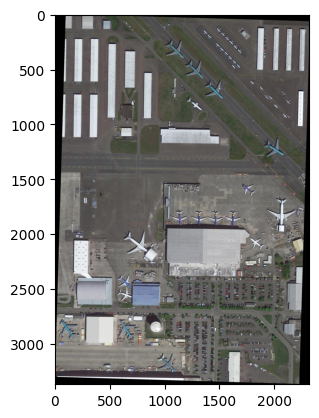

torch.Size([1, 3, 3369, 2319])


In [34]:
this_image = skimage.io.imread("P0024.png")
plt.imshow(this_image)
plt.show()
imgs = torch.Tensor(this_image.astype(float)) 
imgs = einops.rearrange(imgs, "Y X C -> () C Y X")
print(imgs.shape)

In [37]:
labels = torch.tensor(np.load("aiport_labels2.npy")).unsqueeze(0)-1

In [38]:
qlty_obj = NCYXQuilt(X=labels.shape[-1], 
                     Y=labels.shape[-2], 
                     window=(128,128), 
                     step=(64,64), 
                     border=(16,16)
                    )
qimg,qlbls = qlty_obj.unstitch_data_pair(imgs, labels)
print(qimg.shape)
clean_imgs, clean_lbls, _ = weed_sparse_classification_training_pairs_2D(qimg, 
                                                                      qlbls, 
                                                                      missing_label=-1,
                                                                      border_tensor=qlty_obj.border_tensor()
                                                                     )

torch.Size([1872, 3, 128, 128])


In [32]:
epochs=50
for ii in range(3):
    train_loader,test_loader = randomized_data_loader.build_randomized_loader(
        clean_imgs, clean_lbls, use_fraction=0.75)
    in_channels = 3
    out_channels = 2
    num_layers = 15
    hidden_out_channels = [5]
    alpha = 0.0
    gamma = 0.0
    dilation_choices = [1,2,3,4]
    layer_probabilities={'LL_alpha':alpha,
                     'LL_gamma': gamma,
                     'LL_max_degree':num_layers,
                     'LL_min_degree':1,
                     'IL': 0.995,
                     'LO': 0.995,
                     'IO': True}
    sizing_settings = {'stride_base':2, #better keep this at 2
                   'min_power': 0,
                   'max_power': 0}
    torch.cuda.empty_cache()
    print("Network %i"%(ii+1))
    net = smsnet.random_SMS_network(in_channels=in_channels,
                                    out_channels=out_channels,
                                    sizing_settings=sizing_settings,
                                    layers=num_layers,
                                    dilation_choices=dilation_choices,
                                    hidden_out_channels=hidden_out_channels,
                                    layer_probabilities=layer_probabilities,
                                    network_type="Classification")

    weights = torch.tensor([1.0,2.0])
    criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=-1)   # For segmenting
    learning_rate = 1e-3
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    device = helpers.get_device()
    net = net.to(device)
    tmp = train_scripts.train_segmentation(net,
                                           train_loader,
                                           test_loader,
                                           epochs,
                                           criterion,
                                           optimizer,
                                           device,
                                           show=1)
    
    
    
    

Network 1
Epoch 1 of 50 | Learning rate 1.000e-03
   Training Loss: 5.2531e-01 | Validation Loss: 3.3108e-01
   Micro Training F1: 0.8194 | Micro Validation F1: 0.9436
   Macro Training F1: 0.4765 | Macro Validation F1: 0.5370
Epoch 2 of 50 | Learning rate 1.000e-03
   Training Loss: 2.7670e-01 | Validation Loss: 2.2693e-01
   Micro Training F1: 0.9425 | Micro Validation F1: 0.9488
   Macro Training F1: 0.5790 | Macro Validation F1: 0.5880
Epoch 3 of 50 | Learning rate 1.000e-03
   Training Loss: 2.1960e-01 | Validation Loss: 1.8606e-01
   Micro Training F1: 0.9395 | Micro Validation F1: 0.9523
   Macro Training F1: 0.6207 | Macro Validation F1: 0.6518
Epoch 4 of 50 | Learning rate 1.000e-03
   Training Loss: 1.8533e-01 | Validation Loss: 1.7667e-01
   Micro Training F1: 0.9531 | Micro Validation F1: 0.9426
   Macro Training F1: 0.6253 | Macro Validation F1: 0.6787
Epoch 5 of 50 | Learning rate 1.000e-03
   Training Loss: 1.5715e-01 | Validation Loss: 1.5933e-01
   Micro Training F1: 0

KeyboardInterrupt: 